# Image denoising with TurboGP using multiple CPUs in parallel.

TurboGP can take advantage of multi-core/multi-threaded CPUs. Used correctly, this feature allows to speed up processing almost $\times$ times the number of CPUs available (near 100% effiency). This means that a GP can be accelerated four, eight, etc. times, depending on how many CPUs are available/allocated to be used by TurboGP.

Parallel processing in TurboGP can happen in three different modes:

1. __Parallel sample processing__. In parallel sample processing, samples evaluation is performed in parallel, i.e. when evaluating the fitness of a single individual, TurboGP will distribute the evaluation of the training set, or mini-batch, samples across all allocated CPUs. This is the least efficient form of parallelization, because launching multiple threads carries an overhead, and if using on-line learning, the computational cost of such overhead will almost certainly be larger than using a single thread on a single individual. This method is only useful when performing off-line learning (using the entire training set for evaluation each generation) and with large datasets, but then again, one would be giving up the advantages (speed-up gains, regularization) of online learning. Therefore, this is the least recommended method to use.

2. __Parallel individual processing__. In this mode, TurboGP will split the evaluation of the population individuals across all allocated CPUs, i.e. different individuals will be sent to each CPU to perform fitness evaluation. Parallel individual evaluation is relatively simple to use (requires no changes to the code or algorithms), is compatible with on-line learning, and offers a high parallelization efficiency. There are some minor considerations to be taken, though:
    - Mini-batches should not be super small. Anything above 300 samples should be fine, or maybe even 100, depending on the single threaded performance of the CPU in use. Mini-batches of size 50 or less, will lead to a multithreading overhead that will outcost the potential benefits of using multiple processing cores.
    - Individuals should not be super large (max tree depth of 15). Notice how in this mode, although indivudals are being evaluated in parallel, genetic operations are still performed sequentially by a single CPU/thread. Therefore, if you have incredible large individuals, and rather small mini-batches, you might end up spending more time performing mutations and crossovers, than the CPU time being spent on evaluating individuals fitness.
    - Populations should be large (above 200 individuals), but not super large (less than 8000 individuals). Similarty to what happens in parallel sample processing, or when mini-batches are too small in this mode, if population size is set to be too small, the overhead of launching processes in parallel will outcost the actual time spent carrying them out. But on the other hand, very large population can cause issues related to the point mentioned above: genetic operations are still performed sequentially, so very large population may take a heavy toll on performance, even when this parallelization mode is enabled.

3. __Parallel multipopulation processing__. This mode offers the highest degree of parallelization, but it is also the hardest to configure. This mode implements multi-population island based model[1], where the population is split into multiple subpopulations, and each population is sent to different CPUs. Depending on the number of subpopulations/CPUs used, this mode can achieve 100% parallel efficiency. For example, in a 4 CPU/threads system, four inslands can be setup, and each CPU will carry all tasks on each island, parallelizing not only individuals evaluation, but genetic operations as well. If the number of CPUs exceed the number of island used, say 16 to 8, this mode still can be used in combination with parallel individual processing happening in each island, therefore partially parallelizing genetic operations too. This method also offers all benefits of multi-population evolutionary algorithms[1], as such it is a very powerful setup. But as said, it is the hardest to configure, because requires setting up the migration operations.

This notebook will cover __Parallel Individual processing__ only, as it is the easier to use, and it is not difficult to calibrate to obtain high parallel efficiency. 

## Image denoising

We will be using a new target problem as well: image denoising. Image denoising consists in obtaining a clean image from a noisy observation. For example, filtering can be considering image denoising, but there are others as well (such as deblocking, super resolution, etc.). It is a supervised learning tasks, since you show the algorithm, both noisy images and their original clean versions, so it must generate a model that can transform the noisy ones as close as possible to their clean versions. It is a real life application of regression.

Here we will keep it simple, as with out other notebooks, and will perform only filtering. The algorithm will be shown grayscale images contaminated with gaussian noise of certain level, and must attempt to generate a model that cleans them. For a more formal explanation on image filtering with GP, and some results reported with TurboGP, please refer to [2].


`1. Tomassini, M. (2006). Spatially structured evolutionary algorithms: Artificial evolution in space and time. Springer Science & Business Media.`

`2. Rodriguez-Coayahuitl, L., Morales-Reyes, A., & Escalante, H. J. (2019, November). A Comparison among Different Levels of Abstraction in Genetic Programming. In 2019 IEEE International Autumn Meeting on Power, Electronics and Computing (ROPEC) (pp. 1-6). IEEE.`

If we want to use multiple CPU with TurboGP, it is advised that you __disable multithreaded processing on the linear algebra packages you are using__; otherwise, this multiprocessing might interfere with multiprocessing as implemented in TurboGP (which is much more efficient, in this context of evolutionary computation). This can be done, first by determining which linear algebgra package are you using (Intel or Open), and then disable multithreading on it accordingly:

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'                         # For Intel Math Kernel Library
#os.environ['OPENBLAS_NUM_THREADS'] = '1'                   # For OpenBLAS

# if unsure which one you are using, type this command in a python terminal, after importing numpy.
#numpy.__config__.show()      

Next, the usual library declaration part

In [2]:
%matplotlib notebook

# Required Python libraries
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from networkx.drawing.nx_agraph import graphviz_layout

# TurboGP libraries
from GPIndividuals import *      
from GPOperators import *        
from GPflavors import *          
from LowLevel import *           
from Mezzanine import *          
from HighLevel import *          
from Trimmers import *           
from GPUtils import *            
from Utils import *              

# This is useful for when there is overflow, so output cells do not fill with warning messages.
# Disable to debug
import warnings
warnings.simplefilter('ignore')

We will be requiring a few extra libraries though:

In [3]:
from six.moves import cPickle as pickle                 # To load the dataset we will be using

from NonConvolutionalFilter import *                    # This is the GP individual we will use.

from matplotlib.colors import Normalize                 # To plot image patches

NonConvolutionalFilter is a GP regressor specially modified for image filtering (can slide convoluionally across images).

Now, let's load the dataset we will be using. This dataset consist of over 14,000 images patches of 21x21 pixels in size. These patches were extracted from the Berkeley Segmentation Dataset (BSDS)[3]. You can download the dataset from here:

[https://www.dropbox.com/s/5pcmbw9dspbfdt0/bsds50-21x21-mini.npz?dl=0](https://www.dropbox.com/s/5pcmbw9dspbfdt0/bsds50-21x21-mini.npz?dl=0) (about 100MB in size)

or, optionally, you can download the entire original BSDS collection, and extract manually the patches using the following script:

[https://www.dropbox.com/s/nx5ns0g6g00d1sd/BSDS-Shuffle-ResidualCorrected-21x21.ipynb?dl=0](https://www.dropbox.com/s/nx5ns0g6g00d1sd/BSDS-Shuffle-ResidualCorrected-21x21.ipynb?dl=0)

`3.Martin, D., Fowlkes, C., Tal, D., & Malik, J. (2001, July). A database of human segmented natural images and its application to evaluating segmentation algorithms and measuring ecological statistics. In Proceedings Eighth IEEE International Conference on Computer Vision. ICCV 2001 (Vol. 2, pp. 416-423). IEEE.`

The npz file already provides clean patches, noisy patches, and the noise mask of each sample. Here, we will use the noisy images and the noise masks to perform a _residual_ approach. So models generated will atempt to predict the noise level, rather the actual value of the pixel. Clean pixels can be obtained by subtracting the noise prediction from the noisy sample.


In [4]:
# Load file
f = np.load('bsds50-21x21-mini.npz', allow_pickle=True)

# Load images only
x_training = f['x_train_50']
y_training = f['y_residual_50']

# What they look like? (in an array sense)
print(x_training.shape)
print(y_training.shape)

(14000, 21, 21)
(14000, 21, 21)


14,000 samples, of 21x21 grayscale pixels. We will use 12,000 for training purposes and 2,000 as testing dataset:

In [5]:
x_train = x_training[0:12000]
y_train = y_training[0:12000]

batchesX = x_train.reshape(40, 300, 21, 21)
batchesY = y_train.reshape(40, 300, 21, 21)

x_test = x_training[12000:14000]
y_test = y_training[12000:14000]

Notice how we split the training dataset in 40 batches of 300 samples each. This is one of the critial points of __parallel individual processing__ approach; __mini-batches cannot be too small__.

Let's pick the set of primitives we would like to use to tackle this problem. In this example notebook we will only use low-level primitives. See next notebook, to contrast and compare agains the performance of a mezzanine-level enabled GP.

In [6]:
# Each of these functions must be properly defined in the corresponding python modules.
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'MAX', 'MEAN', 'MIN', 'X2', 'SIN', 'COS', 'SQRT']
mezzanine = None
highlevel = None


# Now we let the Node objects know the set of input based primitives available at each layer.
Node.f1_set=lowlevel
Node.f2_set=mezzanine
Node.f3_set=highlevel

# This is the range of constants leaf nodes can take a value from (when not taking the form of a input variable)
Node.i2_set=[-1.0,1.0]

Now, the rest of the GP hyperparameters

In [7]:
pop_size = 1000                                   # Population size

oper = [NonConvFilter.mutation,                  # Genetic operations to use.
        NonConvFilter.protected_crossover]       # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                             # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                              # How many parents required by each operation.

l_rate = 1.0                                     # Offspring pool size, defined as the ratio to the population size.

minimization = True                              # if it is a minimization problem or not
sel_mechanism = binary_tournament                # Preferred selection mechanism for parent selection

Now let's create the initial population. Since this is a harder problem than the one presented in the previous examples, we will increase max tree depth size to 9. For this class of GP individual, we also need to define the size of image patches.

In [8]:
%%time
Population = []

for _ in range(pop_size):
        Population.append(NonConvFilter(lateral_window_size = 21, complexity = 9))

CPU times: user 924 ms, sys: 20 ms, total: 944 ms
Wall time: 922 ms


Remember that this is another of the critical points when using multiple CPUs. Max tree depth should not be beyond 15 or 20, because otherwise genetic operaitons (that are carried sequentially) will consume most time of the run.

Let's see how long does it take to evaluate the entire population on a single mini-batch. This first evaluation is performed by a single CPU.

In [9]:
%%time
#initial evaluation
for individual in Population:
    individual.fitness(batchesX[-1], batchesY[-1])


CPU times: user 4.68 s, sys: 0 ns, total: 4.68 s
Wall time: 4.67 s


It marked around 4.5 seconds in our system (a non-overclocked Core i5 7600k@4.2GHz). Remember that, due to the nature of online-learning, this value will double once we launch a Steady State pop dynamics, which will be around 10 second per cycle, if we were using a single CPU. 10 seconds is on the limit for parallelization with few cores/threads, as in our system (shorter times would make parallelization counterproductive). So now we will launch the evolutionary run, throwing at it all the cores available in our system (4 in our old Core i5). 

To do this, the only thing we are required to do, is to call a special version of Steady_State method that supports parallel individual evaluation, Steady_StateMP. But first, let's set the number of epochs desired for this GP run.

In [10]:
# Set number of epochs:
epochs = 3

no_batches = len(batchesX)
Generations = no_batches * epochs

# Lists for storing statistics:
diversity = []
fitness = []
test_fitness = []

Now that everyhing is setup, we can launch the evolutionary process.

<IPython.core.display.Javascript object>


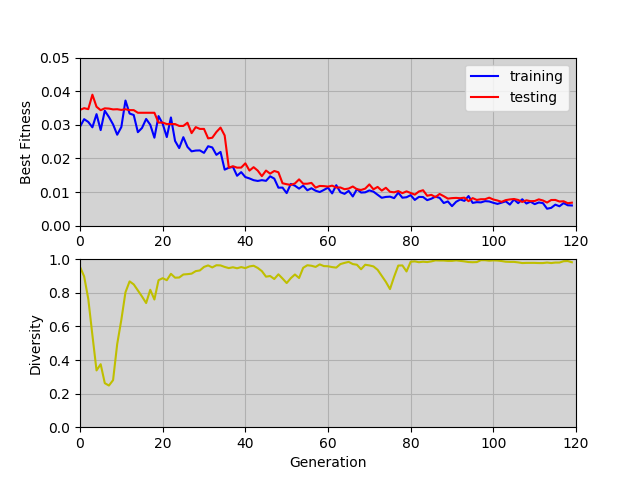

100%|██████████| 120/120 [12:00<00:00,  6.00s/it]


In [11]:
############################################################################################################
# The following piece of code, will allow us to display -in real time- the progress of training fitness,   #
# testing fitness and diversity decay. It is a bit overcomplicated, and it is optional of course, but it   #
# is very useful to understand and visualize if the GP is achieving convergence.                           #

x = list(range(Generations))                                                                               #

y = np.empty(Generations)                                                                                  #
y[:]=np.nan                                                                                                #
y2 = np.empty(Generations)                                                                                 #
y2[:]=np.nan                                                                                               #
d3 = np.empty(Generations)                                                                                 #
d3[:]=np.nan                                                                                               #

plt.ion()                                                                                                  #
fig = plt.figure()                                                                                         #
ax = fig.add_subplot(211)                                                                                  # 
ax.set_ylabel('Best Fitness')                                                                              #
ax.set_ylim(0.0,0.05)                                                                                       #
ax.set_xlim(0,Generations)                                                                                 #
ax.set_facecolor('lightgray')                                                                              #  
ax.grid(True)                                                                                              #
ax2 = fig.add_subplot(212)                                                                                 #
ax2.set_xlabel('Generation')                                                                               #
ax2.set_ylabel('Diversity')                                                                                #
ax2.set_ylim(0.0,1.0)                                                                                      #
ax2.set_xlim(0,Generations)                                                                                #
ax2.set_facecolor('lightgray')                                                                             #
ax2.grid(True)                                                                                             #

line1, = ax.plot(x, y, 'b-', label='training')                                                             #
line2, = ax.plot(x, y2, 'r-', label='testing')                                                             #
line3, = ax2.plot(x, d3, 'y-')                                                                             #
ax.legend()                                                                                                #
############################################################################################################

pbar = tqdm.tqdm(total=Generations)                        

i = 0                          
for e in range(epochs):
    
    for j in range(no_batches):
        
        Population, d, bf, tf = Steady_StateMP(Population = Population,
                                               batch = batchesX[j],           
                                               labels = batchesY[j],
                                               test_batch = x_test,
                                               test_labels = y_test,
                                               l_rate = l_rate,
                                               oper = oper,
                                               oper_prob = oper_prob,
                                               oper_arity = oper_arity,
                                               minimization = minimization,
                                               sel_mechanism = sel_mechanism,
                                               online = True,
                                               pro = 4)             # Everything is the same as in previous example
                                                                    # except for the name of the function we are 
                                                                    # calling, and this last parameter that indicates
                                                                    # how many CPUs/threads we want to use.
        
        diversity.append(d)
        fitness.append(bf)
        test_fitness.append(tf)

        # For live plotting #################
        y[i]=fitness[i]
        y2[i]=test_fitness[i]
        d3[i]=diversity[i]

        line1.set_ydata(y)
        line2.set_ydata(y2)
        line3.set_ydata(d3)

        fig.canvas.draw()
        #####################################
        
        i += 1
        pbar.update(1)      
    
pbar.close()

If you have a CPU usage monitoring app, launch it and observe the plots indicating the usage on each CPU/thread. You should see a uniform use of all the cores across time. If you notice an inconsistent use on all cores, and that only a single CPU is used most of the time (generating a too spiky or even a square signal CPU usage on most of the cores), it means that either mini-batches are not big enough, inviduals are too large, and/or the population is too big. The easiest way to increase parallel efficiency, is by increasing mini-batch size (without having to sacrifice in pop size or individuals depth). Don't be shy in your mini-batches size; most of the times, the hardest problems will require large batch sizes.

One way or another, the highest parallel efficiency under this model can only be achieved by finding the right balance between mini-batch size / max tree depth / and population size. These parameters and relationship will also depend on the problem your tackling, the number of cores your system has, and its single-threaded performance as well. You can only find the right setup by experimentation alone.

Let's see how well we did:

In [12]:
print("Training fitness of best individual found: ", fitness[-1])
print("Testing  fitness of best individual found: ", test_fitness[-1])

Training fitness of best individual found:  0.005991478544055345
Testing  fitness of best individual found:  0.006823569003557047


Results above are expressed in MSE.

Let's get the best individual found:

In [13]:
solver = elite_selection(population=Population, amount=1, minimization=minimization)[0]

and see what it looks like:

<IPython.core.display.Javascript object>


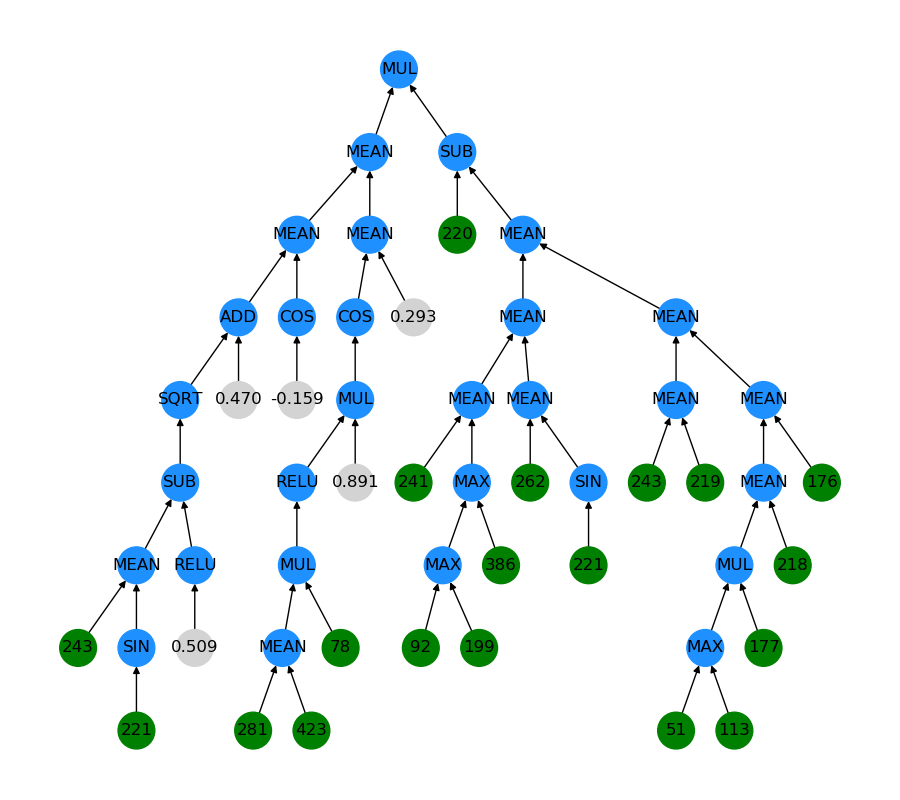

In [14]:
plt.figure(figsize=(9,8))
graph, labels, color_map = get_graph(solver.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

Now lets see in a visual way the performance of the obtained model.

We will plot 10 of the original patches, next to their noisy versions and to also next to the versions _cleaned_ by the individual depicted above.

First, clean some patches using the obtained model. Remember that we used a residual approach, so the model actually returns a noise mask that should be substracted from the noisy patch:

In [15]:
decoded_imgs = []

for x in range (10):
    noise_mask = solver.predict(x_training[x])
    reconstruction = x_training[x] - noise_mask
    decoded_imgs.append(reconstruction)

Lets pull from the dataset the clean, original, versions of the patches:

In [16]:
y_label = f['y_train']

Plot them. First row, original; next, noisy; last row, GP reconstructions.

<IPython.core.display.Javascript object>


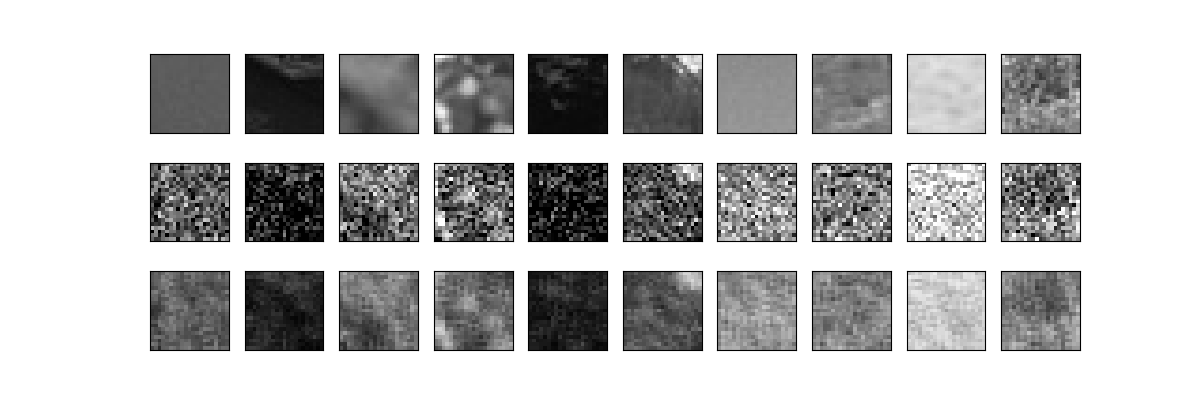

In [17]:
norm = Normalize(vmin=0, vmax=1, clip=True)

n = 10  # how many digits we will display
plt.figure(figsize=(12, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_label[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_training[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(decoded_imgs[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As we can see, considering the noise level with which the patches were contaminated, the GP generated model performance is not bad at all. Although it struggles with smooth surfaces (such as the sky).

Do not get discouraged if you don't get results this good after a few runs of this notebook; image denoising is a difficult problem for GP, given its high dimensional feature space (441 pixels/feature variables). You can also get better results and higher parallel efficiency by increasing batch size, at the cost of a longer run-time.

In the next notebook we will see how the performance of GP generated models can be further enhanced by means of _mezzanine_ primitives, which are a defacto standard in modern GP implementations aimed at high dimensional problems.